In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt
import numpy as np
import json
from IPython.display import IFrame
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import copy
from folium.plugins import TimestampedGeoJson


In [9]:
df_b = pd.read_csv('data/fuellstandsensoren-glassammelstellen-braunglas.csv',sep=';')
df_w = pd.read_csv('data/fuellstandsensoren-glassammelstellen-weissglas.csv',sep=';')
df_g = pd.read_csv('data/fuellstandsensoren-glassammelstellen-gruenglas.csv',sep=';')


In [10]:
df_b = df_b.assign(color='b')
df_w = df_w.assign(color='w')
df_g = df_g.assign(color='g')

df_glass = pd.concat([df_b, df_w, df_g])
# Split 'geo_point_2d' into 'latitude' and 'longitude'
df_glass[['latitude', 'longitude']] = df_glass['geo_point_2d'].str.split(',', expand=True).astype(float)



In [38]:
print(df_b.shape[0] + df_w.shape[0] + df_g.shape[0] == df_glass.shape[0])
# True -> all rows are in the new dataframe
print(df_glass.shape)
df_glass.head(3)

True
(2342756, 12)


,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,fill_level
0,2020-02-24T09:52:09+01:00,"{""foo"": 3}",4f48bac6-9d0e-4879-93ad-5bf39b4c5915,107109 | 67EF,526a0ccc-00ab-4a7f-ac15-ee173dac7360,"{""coordinates"": [9.360562526050046, 47.4257577...",NaN,"47.42575774663251, 9.360562526050046",b,47.425758,9.360563,NaN
1,2020-02-24T09:42:33+01:00,"{""foo"": 3}",1e8d1b09-d186-495e-bd1f-cb06afdd5b21,107054 | 2AE2,1e042495-21da-40b4-87cf-5fccba5eb770,"{""coordinates"": [9.34623629581722, 47.41967910...",NaN,"47.419679102687155, 9.34623629581722",b,47.419679,9.346236,NaN
2,2020-02-24T09:18:36+01:00,"{""foo"": 3}",473a8148-3001-42ec-946e-55d479bfc9c4,107053 | 667E,67118b4f-5eb2-4f1d-b885-f0f367233e32,"{""coordinates"": [9.333639241159204, 47.4079475...",NaN,"47.40794753166517, 9.333639241159204",b,47.407948,9.333639,NaN


In [12]:
unique_locations = df_glass['location'].unique()
print("Unique locations:",len(unique_locations))
unique_ids = df_glass['id'].unique()
print(len(unique_ids), "id stands for datapoint entry <-- useless")
unique_devices = df_glass['device_id'].unique()
print("Unique devices:",len(unique_devices))

print("how about the single colors?")
# For df_b (Brown)
print("Brown")
unique_locations_b = df_b['location'].unique()
print("Unique locations in brown:", len(unique_locations_b))
unique_devices_b = df_b['device_id'].unique()
print("Unique devices in brown:", len(unique_devices_b))

# For df_w (White)
print("White")
unique_locations_w = df_w['location'].unique()
print("Unique locations in white:", len(unique_locations_w))
unique_devices_w = df_w['device_id'].unique()
print("Unique devices in white:", len(unique_devices_w))

# For df_g (Green)
print("Green")
unique_locations_g = df_g['location'].unique()
print("Unique locations in green:", len(unique_locations_g))
unique_devices_g = df_g['device_id'].unique()
print("Unique devices in green:", len(unique_devices_g))


print("total unique locations b+w+g:", len(unique_locations_b) + len(unique_locations_w) + len(unique_locations_g))

Unique locations: 62
2342756 id stands for datapoint entry <-- useless
Unique devices: 62
how about the single colors?
Brown
Unique locations in brown: 16
Unique devices in brown: 16
White
Unique locations in white: 21
Unique devices in white: 21
Green
Unique locations in green: 25
Unique devices in green: 25
total unique locations b+w+g: 62


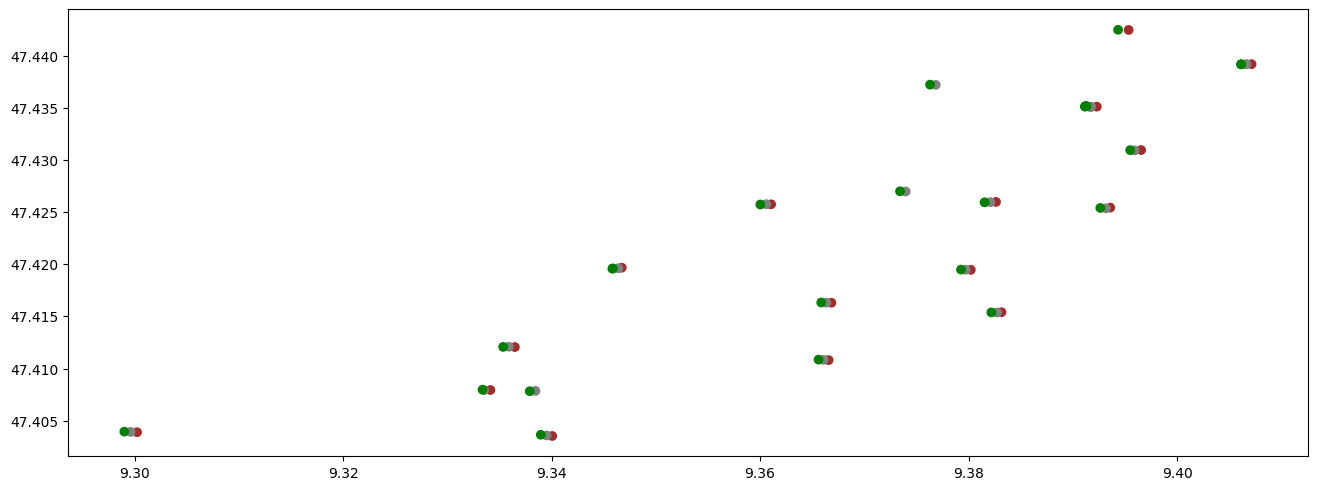

In [13]:
# Remove duplicate rows based on 'geo_point_2d'
df_glass_unique = df_glass.drop_duplicates(subset='geo_point_2d')

# Shift amount for longitude
shift_amount = 0.0005  # Adjust this value as needed

# Shift green points to the left and brown points to the right (for better visibility)
df_glass_unique.loc[df_glass_unique['color'] == 'g', 'longitude'] -= shift_amount
df_glass_unique.loc[df_glass_unique['color'] == 'b', 'longitude'] += shift_amount

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_glass_unique['longitude'], df_glass_unique['latitude'])]
geo_df_unique = gpd.GeoDataFrame(df_glass_unique, geometry=geometry)

# Map 'color' values to actual colors
color_map = {'b': 'brown', 'g': 'green', 'w': 'grey'}
geo_df_unique['plot_color'] = geo_df_unique['color'].map(color_map)

# Specify the size of the plot
fig, ax = plt.subplots(figsize=(16, 12))  # Adjust the dimensions as needed
geo_df_unique.plot(ax=ax, color=geo_df_unique['plot_color'])


plt.show()


In [14]:
color_counts = df_glass_unique["color"].value_counts()
color_counts

g    25
w    21
b    16
Name: color, dtype: int64

# adding the locations to the folium map

In [15]:
# Load the GeoJSON file
file_path = 'data/wohnviertel_stadt-stgallen.geojson'  # Replace with your file path
with open(file_path, 'r') as file:
    geojson_data = json.load(file)

# Create a map centered around the general area of St. Gallen
map_center = [47.424482, 9.376717]  # Latitude and Longitude of St. Gallen
folium_map = folium.Map(location=map_center, zoom_start=13)

# Adding the GeoJSON data to the map 
# uncomment the following line to get rid of the borders/nieghbourhoods
folium.GeoJson(geojson_data).add_to(folium_map)

# Remove duplicate rows
df_glass_unique = df_glass.drop_duplicates(subset=['geo_point_2d', 'color']).reset_index(drop=True)
# color does actually not matter, since the coordinate are for each container, not collection point.


# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_glass_unique['longitude'], df_glass_unique['latitude'])]
geo_df_unique = gpd.GeoDataFrame(df_glass_unique, geometry=geometry)

# Color sensors with NAN values in red
# Lists of faulty device IDs
faulty_devices_gruenglass = ['aae16e11-7f7e-4251-9e73-fd836db67b79', '7f9cad51-8a0c-4fa9-a6d4-8cf649d819ab', 
                             '496ebab5-e27f-46a4-91bd-28e5086eb594', '96e70afa-3ce0-4674-a331-8b85aed97068', 
                             'a3e91e80-9b8d-4bd6-bbd7-011319e05a0c']
faulty_devices_weissglass = ['473a8148-3001-42ec-946e-55d479bfc9c4', '624e62e7-2b0b-43dc-a992-77ab95adbbb8', 
                             'bd1f5d39-0361-4717-9054-845ac2fa33bd', 'fa37f819-027b-4f6e-8e7d-1c80488f036f']
faulty_devices_braunglass = ['4f48bac6-9d0e-4879-93ad-5bf39b4c5915', '473a8148-3001-42ec-946e-55d479bfc9c4', 
                             '624e62e7-2b0b-43dc-a992-77ab95adbbb8', 'fa37f819-027b-4f6e-8e7d-1c80488f036f', 
                             'bd1f5d39-0361-4717-9054-845ac2fa33bd']

# Combine all broken device IDs into a single list
all_faulty_devices = list(set(faulty_devices_gruenglass + faulty_devices_weissglass + faulty_devices_braunglass))

# Map 'color' values to actual colors
color_map = {'b': 'brown', 'g': 'green', 'w': 'grey'}  # grey instead of white for better visibility
geo_df_unique['plot_color'] = geo_df_unique['color'].map(color_map)

# Update 'plot_color' to 'black' for broken devices
geo_df_unique.loc[geo_df_unique['device_id'].isin(all_faulty_devices), 'plot_color'] = 'black'


# Adding each point from the GeoDataFrame to the Folium map with a tooltip showing the index
for index, row in geo_df_unique.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,  # Adjust the radius as needed
        color=row['plot_color'],
        fill=True,
        fill_color=row['plot_color'],
        #tooltip="Index: "+str(index)+", Name: "+str(row['name']),  # Show the index as a tooltip on hover
        popup="Index: "+str(index)+", Name: "+str(row['name']+", Color: "+str(row['color'])) # Show the index click on the marker
    ).add_to(folium_map)

# Display the map in a Jupyter notebook
folium_map

In [16]:
geo_df_unique.tail(3)

,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,geometry,plot_color
59,2020-03-06T13:12:28+01:00,"{""foo"": 3}",a82a9f13-4ec0-45bd-a218-4e2cc4ca11bb,107070 | 454B,92d3999f-eded-424f-8c26-389804700d8d,"{""coordinates"": [9.338409956002408, 47.4078311...",NaN,"47.407831127695545, 9.338409956002408",g,47.407831,9.338410,POINT (9.33841 47.40783),green
60,2020-03-06T11:43:48+01:00,"{""foo"": 3}",e194deb4-afb0-4c83-aab2-71fcd13ca4e8,107131 | 808C,458ffc19-fa01-4a23-b8f0-a6c23bfe87f5,"{""coordinates"": [9.39600777236538, 47.43095608...",NaN,"47.43095608319004, 9.39600777236538",g,47.430956,9.396008,POINT (9.39601 47.43096),green
61,2020-07-03T12:41:20+02:00,"{""type"": ""reading"", ""distance"": 1354}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,645aad7b-73c7-4b6f-96c6-d642a564c6eb,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1354.0,"47.4425, 9.39485",g,47.442500,9.394850,POINT (9.39485 47.44250),green


In [33]:
def parse_coordinates(df, coord_col):
    lat, lon = [], []
    for coord in df[coord_col]:
        lat_val, lon_val = map(float, coord.split(', '))
        lat.append(lat_val)
        lon.append(lon_val)
    return lat, lon

def cluster_coordinates(df, eps_meters=15, min_samples=10):
    # Convert eps from meters to degrees
    kms_per_radian = 6371.0088
    eps_in_degrees = eps_meters / 1000.0 / kms_per_radian

    # Get latitudes and longitudes
    latitudes, longitudes = parse_coordinates(df, 'geo_point_2d')

    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps_in_degrees, min_samples=min_samples, algorithm='ball_tree', metric='haversine')
    db.fit(np.radians(np.column_stack((latitudes, longitudes))))

    # Add cluster labels to DataFrame
    df['cluster_nr'] = db.labels_
    return df

def add_cluster_details(df):
    clusters = df.groupby('cluster_nr')
    df['cluster_ids'] = df['cluster_nr'].apply(lambda x: clusters.get_group(x)['device_id'].tolist())
    df['cluster_coords'] = df['cluster_nr'].apply(lambda x: clusters.get_group(x)['geo_point_2d'].tolist())
    return df

def calculate_cluster_center(coords_list):
    latitudes, longitudes = [], []
    for coord in coords_list:
        lat, lon = map(float, coord.split(', '))
        latitudes.append(lat)
        longitudes.append(lon)
    # Calculate the average of latitudes and longitudes
    center_lat, center_lon = sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)
    return center_lat, center_lon





# Clustering with a threshold of 20 meters
df_glasscontainers = cluster_coordinates(df_glass_unique, eps_meters=20, min_samples=1)
df_glasscontainers = add_cluster_details(df_glass_unique)
df_glasscontainers['cluster_center'] = df_glasscontainers['cluster_coords'].apply(calculate_cluster_center)
df_glasscontainers.to_csv('glascontainer_cluster.csv', index=False) 
df_glasscontainers.head(3)



,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,geometry,plot_color,cluster_nr,cluster_ids,cluster_coords,cluster_center
0,2020-02-24T09:52:09+01:00,"{""foo"": 3}",4f48bac6-9d0e-4879-93ad-5bf39b4c5915,107109 | 67EF,526a0ccc-00ab-4a7f-ac15-ee173dac7360,"{""coordinates"": [9.360562526050046, 47.4257577...",NaN,"47.42575774663251, 9.360562526050046",b,47.425758,9.360563,POINT (9.36056 47.42576),black,0,"[4f48bac6-9d0e-4879-93ad-5bf39b4c5915, 7d1d7a9...","[47.42575774663251, 9.360562526050046, 47.4257...","(47.425756721972, 9.360562788475226)"
1,2020-02-24T09:42:33+01:00,"{""foo"": 3}",1e8d1b09-d186-495e-bd1f-cb06afdd5b21,107054 | 2AE2,1e042495-21da-40b4-87cf-5fccba5eb770,"{""coordinates"": [9.34623629581722, 47.41967910...",NaN,"47.419679102687155, 9.34623629581722",b,47.419679,9.346236,POINT (9.34624 47.41968),brown,1,"[1e8d1b09-d186-495e-bd1f-cb06afdd5b21, d4a9fa6...","[47.419679102687155, 9.34623629581722, 47.4196...","(47.4196237469368, 9.346338819150589)"
2,2020-02-24T09:18:36+01:00,"{""foo"": 3}",473a8148-3001-42ec-946e-55d479bfc9c4,107053 | 667E,67118b4f-5eb2-4f1d-b885-f0f367233e32,"{""coordinates"": [9.333639241159204, 47.4079475...",NaN,"47.40794753166517, 9.333639241159204",b,47.407948,9.333639,POINT (9.33364 47.40795),black,2,"[473a8148-3001-42ec-946e-55d479bfc9c4, 632c0d3...","[47.40794753166517, 9.333639241159204, 47.4079...","(47.407952426468604, 9.333681499699862)"


In [32]:
check_sum = 0
# 19 collection locations (clusters) are found and according to the map
for element in df_glasscontainers['cluster_nr'].unique():
    print("Cluster",element, ":","Container count:",len(df_glasscontainers[df_glasscontainers['cluster_nr'] == element]['cluster_ids']))
    print(df_glasscontainers[df_glasscontainers['cluster_nr'] == element]['cluster_ids'])
    check_sum += len(df_glasscontainers[df_glasscontainers['cluster_nr'] == element]['cluster_ids'])

print("checksum:",check_sum)





Cluster 0 : Container count: 3
0     [4f48bac6-9d0e-4879-93ad-5bf39b4c5915, 7d1d7a9...
32    [4f48bac6-9d0e-4879-93ad-5bf39b4c5915, 7d1d7a9...
43    [4f48bac6-9d0e-4879-93ad-5bf39b4c5915, 7d1d7a9...
Name: cluster_ids, dtype: object
Cluster 1 : Container count: 4
1     [1e8d1b09-d186-495e-bd1f-cb06afdd5b21, d4a9fa6...
17    [1e8d1b09-d186-495e-bd1f-cb06afdd5b21, d4a9fa6...
42    [1e8d1b09-d186-495e-bd1f-cb06afdd5b21, d4a9fa6...
54    [1e8d1b09-d186-495e-bd1f-cb06afdd5b21, d4a9fa6...
Name: cluster_ids, dtype: object
Cluster 2 : Container count: 3
2     [473a8148-3001-42ec-946e-55d479bfc9c4, 632c0d3...
21    [473a8148-3001-42ec-946e-55d479bfc9c4, 632c0d3...
47    [473a8148-3001-42ec-946e-55d479bfc9c4, 632c0d3...
Name: cluster_ids, dtype: object
Cluster 3 : Container count: 3
3     [75ba05c7-3c77-4160-a72d-8dc15efee2c5, a54a033...
25    [75ba05c7-3c77-4160-a72d-8dc15efee2c5, a54a033...
45    [75ba05c7-3c77-4160-a72d-8dc15efee2c5, a54a033...
Name: cluster_ids, dtype: object
Cluster 4 : Cont

In [19]:
for index, row in df_glasscontainers.iterrows():
    cluster_center = row['cluster_center']

    # If cluster_center is a string, split it into lat and lon
    if isinstance(cluster_center, str):
        lat, lon = map(float, cluster_center.split(','))
    else:
        # Directly extract latitude and longitude from the list
        lat, lon = cluster_center[0], cluster_center[1]

    # Add a circle to the map
    circle = folium.Circle(
        location=[lat, lon],
        radius=30,  # Radius in meters, you can adjust this
        color='blue',
        fill=False,
        weight=5  # Adjust the thickness of the circle's border
    )

    # Add popup with cluster number
    popup = folium.Popup('Cluster Number: '+str(row['cluster_nr']))
    circle.add_child(popup)

    circle.add_to(folium_map)

# Display the map
folium_map

In [20]:
df_glass.tail(3)

,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude
892930,2023-08-18T18:25:33+02:00,"{""type"": ""reading"", ""distance"": 1483}",496ebab5-e27f-46a4-91bd-28e5086eb594,107108 | 0AEA,134d1529-9637-4873-8047-65bdfbdbd50c,"{""coordinates"": [9.38204, 47.42595], ""type"": ""...",1483.0,"47.42595, 9.38204",g,47.42595,9.38204
892931,2023-08-18T17:55:33+02:00,"{""type"": ""reading"", ""distance"": 1462}",496ebab5-e27f-46a4-91bd-28e5086eb594,107108 | 0AEA,141d9269-4601-4d84-ac78-7e4b13b6326a,"{""coordinates"": [9.38204, 47.42595], ""type"": ""...",1462.0,"47.42595, 9.38204",g,47.42595,9.38204
892932,2023-08-18T17:41:55+02:00,"{""type"": ""reading"", ""distance"": 1247}",aae16e11-7f7e-4251-9e73-fd836db67b79,107055 | 2C76,64511fd0-381d-40a7-931b-dc1a327aa434,"{""coordinates"": [9.39314, 47.42541], ""type"": ""...",1247.0,"47.42541, 9.39314",g,47.42541,9.39314


In [21]:
print(df_glass['data_distance'].max(),"mm is empty or 0% filled")
print(df_glass['data_distance'].min(), "mm is full or 100% filled")

2500.0 mm is empty or 0% filled
300.0 mm is full or 100% filled


In [22]:
def calculate_fill_level(distance):
    if pd.isna(distance):
        return np.nan
    else:
        return (distance - 300) / 2200

# Apply the function to the 'data_distance' column
df_glass['fill_level'] = df_glass['data_distance'].apply(calculate_fill_level)

df_glass.tail(3)

,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,fill_level
892930,2023-08-18T18:25:33+02:00,"{""type"": ""reading"", ""distance"": 1483}",496ebab5-e27f-46a4-91bd-28e5086eb594,107108 | 0AEA,134d1529-9637-4873-8047-65bdfbdbd50c,"{""coordinates"": [9.38204, 47.42595], ""type"": ""...",1483.0,"47.42595, 9.38204",g,47.42595,9.38204,0.537727
892931,2023-08-18T17:55:33+02:00,"{""type"": ""reading"", ""distance"": 1462}",496ebab5-e27f-46a4-91bd-28e5086eb594,107108 | 0AEA,141d9269-4601-4d84-ac78-7e4b13b6326a,"{""coordinates"": [9.38204, 47.42595], ""type"": ""...",1462.0,"47.42595, 9.38204",g,47.42595,9.38204,0.528182
892932,2023-08-18T17:41:55+02:00,"{""type"": ""reading"", ""distance"": 1247}",aae16e11-7f7e-4251-9e73-fd836db67b79,107055 | 2C76,64511fd0-381d-40a7-931b-dc1a327aa434,"{""coordinates"": [9.39314, 47.42541], ""type"": ""...",1247.0,"47.42541, 9.39314",g,47.42541,9.39314,0.430455


In [23]:
# Merging df_glass with df_glasscontainers on 'device_id'
df_glass_merged = pd.merge(df_glass, df_glasscontainers[['device_id', 
                                                            'cluster_nr', 
                                                            'cluster_ids', 
                                                            'cluster_coords', 
                                                            'cluster_center']], on='device_id')


In [24]:
df_glass_merged.tail(3)

,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,fill_level,cluster_nr,cluster_ids,cluster_coords,cluster_center
2342753,2020-06-16T23:12:42+02:00,"{""type"": ""inquiry"", ""battery_voltage"": 3.63}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,668a8bfe-8029-40a5-a7f2-9553fc49d66a,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",NaN,"47.4425, 9.39485",g,47.4425,9.39485,NaN,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)"
2342754,2020-06-16T22:12:38+02:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,56574dbf-b4d3-4641-b205-d45e186fb501,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)"
2342755,2020-06-16T21:42:39+02:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,802423c7-66da-4aa9-8c1c-8303d55cdbf7,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)"


In [45]:
def assign_plot_color(row):
    if pd.isna(row['fill_level']):
        return 'black'
    elif row['fill_level'] < 0.5:
        return 'green'
    elif row['fill_level'] < 0.8:
        return 'orange'
    else:
        return 'red'

# Apply the function to each row
df_glass_merged['plot_color'] = df_glass_merged.apply(assign_plot_color, axis=1)


In [46]:
df_glass_merged.tail(10)

,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,fill_level,cluster_nr,cluster_ids,cluster_coords,cluster_center,plot_color
2342746,2020-06-17 15:42:35+00:00,"{""type"": ""reading"", ""distance"": 1354}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,86879110-f165-46e0-ba05-c8546606fbb6,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1354.0,"47.4425, 9.39485",g,47.4425,9.39485,0.479091,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",green
2342747,2020-06-17 13:12:35+00:00,"{""type"": ""reading"", ""distance"": 1376}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,b48cade2-31f1-4df4-aa19-a7b5742f902d,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1376.0,"47.4425, 9.39485",g,47.4425,9.39485,0.489091,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",green
2342748,2020-06-17 08:42:36+00:00,"{""type"": ""reading"", ""distance"": 1397}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,882f7bcc-57b5-4c6e-aa8b-5b748a253aa7,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1397.0,"47.4425, 9.39485",g,47.4425,9.39485,0.498636,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",green
2342749,2020-06-17 07:12:36+00:00,"{""type"": ""reading"", ""distance"": 1419}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,2eba9c09-0c2e-4e51-a0f2-45e24b6a82ad,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1419.0,"47.4425, 9.39485",g,47.4425,9.39485,0.508636,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",orange
2342750,2020-06-17 03:42:37+00:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,c47b09a8-0a8e-433a-b2eb-25b1d8f05396,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",orange
2342751,2020-06-17 02:42:37+00:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,2d38e057-b8b8-462a-baac-d988c89c1206,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",orange
2342752,2020-06-17 01:42:37+00:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,4df8a790-aa0f-46f2-90d7-85f769ef78bd,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",orange
2342753,2020-06-16 21:12:42+00:00,"{""type"": ""inquiry"", ""battery_voltage"": 3.63}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,668a8bfe-8029-40a5-a7f2-9553fc49d66a,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",NaN,"47.4425, 9.39485",g,47.4425,9.39485,NaN,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",black
2342754,2020-06-16 20:12:38+00:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,56574dbf-b4d3-4641-b205-d45e186fb501,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",orange

In [54]:
# use the full dataset
df_filtered =df_glass_merged 

In [47]:
# Convert 'measured_at' to datetime with UTC
df_glass_merged['measured_at'] = pd.to_datetime(df_glass_merged['measured_at'], utc=True)


# Filter the data for dates between a date to test the code
start_date = '2023-06-01'
end_date = '2023-06-10'
mask = (df_glass_merged['measured_at'] >= start_date) & (df_glass_merged['measured_at'] <= end_date)
df_filtered = df_glass_merged.loc[mask]


In [55]:
df_filtered.tail(3)

,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,fill_level,cluster_nr,cluster_ids,cluster_coords,cluster_center,plot_color
2342753,2020-06-16 21:12:42+00:00,"{""type"": ""inquiry"", ""battery_voltage"": 3.63}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,668a8bfe-8029-40a5-a7f2-9553fc49d66a,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",NaN,"47.4425, 9.39485",g,47.4425,9.39485,NaN,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",black
2342754,2020-06-16 20:12:38+00:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,56574dbf-b4d3-4641-b205-d45e186fb501,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",orange
2342755,2020-06-16 19:42:39+00:00,"{""type"": ""reading"", ""distance"": 1505}",e3a7cfea-c281-46fe-8758-0bf2388181c0,104249,802423c7-66da-4aa9-8c1c-8303d55cdbf7,"{""coordinates"": [9.39485, 47.4425], ""type"": ""P...",1505.0,"47.4425, 9.39485",g,47.4425,9.39485,0.547727,12,"[7cfecc22-d53c-45b4-8eb2-cb8219ca531e, e3a7cfe...","[47.4424846072051, 9.39485711229068, 47.4425, ...","(47.44249230360255, 9.394853556145339)",orange


In [56]:
# Load your GeoJSON data
with open('data/wohnviertel_stadt-stgallen.geojson', 'r') as file:
    geojson_data = json.load(file)

# Create a map centered around St. Gallen
map_center = [47.424482, 9.376717]
folium_map = folium.Map(location=map_center, zoom_start=13)

# Add GeoJSON layer
folium.GeoJson(geojson_data).add_to(folium_map)

# Convert 'measured_at' to datetime and then to string in ISO format
df_filtered['measured_at'] = pd.to_datetime(df_filtered['measured_at']).dt.strftime('%Y-%m-%dT%H:%M:%S')

# Prepare features for TimestampedGeoJson
features = []
for _, row in df_filtered.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']],
        },
        'properties': {
            'time': row['measured_at'],
            'style': {'color': row['plot_color'], 'weight': 1},
            'icon': 'circle',
            'iconstyle': {
                'fillColor': row['plot_color'],
                'fillOpacity': 0.8,
                'stroke': 'true',
                'radius': 3
            },
            'popup': f"Name: {row['name']}, glass color: {row['color']}"
        }
    }
    features.append(feature)

# Add TimestampedGeoJson to the map
TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features
}, period='PT1H', add_last_point=True).add_to(folium_map)

# Display the map in Jupyter Notebook
folium_map
